## **Install required packages**


In [2]:
!pip install progressbar
!pip install pydot

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'progressbar' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'progressbar'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12066 sha256=fd0581b48908b4ca181969b595f413141819ccdc90f91fbe958d139c64d83dad
  Stored in directory: /home/ubuntu/.cache/pip/wheels/8d/bb/b2/5353b966ac6f3c5e1000629a9a5f6aed41794487f551e32efc
Successfully built progressbar


## **Import requiered packages**


In [4]:

import numpy as np
import random
from os import listdir
from os.path import isfile, join
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer,tokenizer_from_json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import json
import gc
from progressbar import ProgressBar

## **Defined constants**


In [5]:
# Constants
#configuration_template_file = 'config_template.txt'
configuration_start_point = '!'
test_samples = 10
context_before = 50
context_after = 50
max_dictionary_size = 50000
top_n_probabilities = 10
probability_threshold = 3
word_variability_threshold = 10
latent_len = 512
training_size = 100000
testing_size = 2000
total_subset = training_size+testing_size
batch_size = 1024
nb_epoch = 10
training_steps_per_epoch = int(np.ceil(training_size/batch_size))
validation_steps_per_epoch = int(np.ceil(testing_size/batch_size))
test_file = 'config_test.cfg'
tokenizer_file = 'tokenizer-pe.json'
model_weights_file = 'weights_config_anomaly_PE_blstm.weights.h5'
path_config_files = './configs'
path_files = './'

## **Define functions**


In [6]:
# Functions

def config_train_test_split(target_configs, test_samples):
  test_files_indexes = random.sample(range(len(target_configs)),test_samples)
  train_configs = []
  test_configs = []
  for i in range(len(target_configs)):
    if i in test_files_indexes:
      test_configs.append(target_configs[i])
    else:
      train_configs.append(target_configs[i])
  return train_configs,test_configs

def find_config_start(config_lines, start_sequence):
  i=0
  config_found = np.False_
  while not config_found:
    if start_sequence in config_lines[i]:
      config_found = True
      config_index = i+1
    else:
      i+=1
  return config_index

def get_lines(config_file):
  file_handle = open(config_file, 'r')
  config_lines = file_handle.readlines()
  return config_lines

def get_config_lines(config_file):
  file_handle = open(config_file, 'r')
  config_lines = file_handle.readlines()
  config_index = find_config_start(config_lines,configuration_start_point)
  return config_lines[config_index:]

def build_corpus(train_configs,path):
  for config_file in train_configs:
    corpus = []
    print('Config:',config_file)
    config_lines = get_config_lines(join(path,config_file))
    for i in range(len(config_lines)):
      corpus += config_lines[i].lower().split()
    yield corpus

def build_tokenizer(train_configs, path):
  tokenizer = Tokenizer(filters='',oov_token='OOV',num_words=max_dictionary_size)
  tokenizer.fit_on_texts(build_corpus(train_configs,path))
  total_words = len(tokenizer.word_index) + 1
  print(total_words)
  return tokenizer

def build_training_data(train_config, tokenizer):
  input_sequences = []
  input_labels = []
  current_index = 0
  corpus = []
  config_lines = get_config_lines(train_config)
  for i in range(len(config_lines)):
      corpus += config_lines[i].lower().split()
  while (current_index + context_before + context_after+1) < len(corpus):
    current_sequence = corpus[current_index:(current_index+context_before)]+corpus[(current_index+context_before+1):(current_index+context_before+context_after+1)]
    current_label = corpus[current_index+context_before]
    token_list = tokenizer.texts_to_sequences([current_sequence])[0]
    token_label = tokenizer.texts_to_sequences([current_label])[0]
    input_sequences.append(token_list)
    input_labels.append(token_label)
    current_index +=1
  xs, labels = np.array(input_sequences),np.array(input_labels)
  ys = tf.keras.utils.to_categorical(labels, num_classes=(dictionary_size))
  return xs,ys

def build_training_data_batch(corpus, tokenizer, start_index, batch_size):
  input_sequences = []
  input_labels = []
  current_index = start_index
  config_finished=False
  for i in range(batch_size):
    if (current_index + context_before + context_after) < len(corpus):
      current_sequence = corpus[current_index:(current_index+context_before)]+corpus[(current_index+context_before+1):(current_index+context_before+context_after+1)]
      current_label = corpus[current_index+context_before]
      token_list = tokenizer.texts_to_sequences([current_sequence])[0]
      token_label = tokenizer.texts_to_sequences([current_label])[0]
      input_sequences.append(token_list)
      input_labels.append(token_label)
      current_index +=1
    else:
      config_finished = True
  xs, labels = np.array(input_sequences),np.array(input_labels)
  ys = tf.keras.utils.to_categorical(labels, num_classes=(dictionary_size))
  return xs,ys,config_finished

def batch_generator(train_configs,path, batch_size, steps):
  xs = []
  ys = []
  i=0
  idx_total=1
  while True:
    config=train_configs[i]
    corpus = []
    config_lines=get_config_lines(join(path,config))
    for j in range(len(config_lines)):
      corpus += config_lines[j].lower().split()

    idx=1
    del xs
    del ys
    gc.collect()
    done_yet = False
    while not done_yet:
      start_index = (idx-1)*batch_size
      xs,ys,done_yet = build_training_data_batch(corpus,tokenizer,start_index,batch_size)
      stop_index = start_index + batch_size
      X_batch = xs
      y_batch = ys
      yield (X_batch,y_batch)
      if not done_yet:
        if idx_total < steps:
            idx +=1
            idx_total +=1
        else:
            idx_total=1
            done_yet=True
      else:
        if idx < steps:
            idx +=1
            if i<(len(train_configs)-1):
              i+=1
            else:
              i=0
        else:
            idx_total=1
            i=0

def predict_config_accuracy(config_file, model, tokenizer):
  xs,ys = build_training_data(config_file, tokenizer)
  score, acc = model.evaluate(xs[0:2000], ys[0:2000])
  return score, acc

def predict_config(config_file, model, tokenizer):
  xs,ys = build_training_data(config_file, tokenizer)
  y_pred = model(xs[0:1000])
  return y_pred

def convert_to_text(y_pred, tokenizer):
  predicted_words_index = [int(np.argmax(y_pred[i,:])) for i in range(y_pred.shape[0])]
  predicted_words = tokenizer.sequences_to_texts([predicted_words_index])[0]
  return predicted_words

def compute_config_anomaly_vector(config_file, model, tokenizer):
  xs,ys = build_training_data(config_file, tokenizer)
  #predicted_prob = model.predict_proba(xs, verbose=0)
  y_pred = model(xs).numpy()
  real_words_index = [int(np.argmax(ys[i,:])) for i in range(ys.shape[0])]
  y_probability = []
  y_recommended = []
  y_prob_conf = []
  for i in range(1,y_pred.shape[0]):
    temp = np.partition(-y_pred[i,:], top_n_probabilities)
    y_pred_average=np.mean(-temp[:top_n_probabilities])
    y_pred_prob = y_pred[i,real_words_index[i]]
    y_recom = np.argmax(y_pred[i,:])
    word_variability = total_nexts[real_words_index[i-1]]
    y_prob_conf = y_pred_prob/y_pred_average
    if word_variability > word_variability_threshold:
      probability = top_n_probabilities
    else:
      probability = y_pred_prob/y_pred_average
    y_probability.append(probability)
    y_recommended.append(y_recom)
  fig, ax = plt.subplots()
  ax.hist(y_prob_conf, bins=30)
  return y_probability,y_recommended

def display_config_anomalies(config_file,model,tokenizer):
  y_probability,y_recommended = compute_config_anomaly_vector(config_file,model,tokenizer)
  config_lines = get_config_lines(config_file)
  corpus = []
  for i in range(len(config_lines)):
      corpus += config_lines[i].lower().split()
  y_words = corpus[context_before+1:-(context_after+1)]
  probability_mask = np.array(y_probability) > probability_threshold
  print('Number of anomalies detected:',(len(y_words)-np.sum(probability_mask)))
  colored_config = ''
  word_index = 0
  for w in range(len(config_lines)):
    tokenized_line = config_lines[w].split()
    for item in tokenized_line:
      if word_index>=(context_before+1) and word_index<(len(corpus)-(context_after+1)):
        if probability_mask[word_index-(context_before+1)]:
          colored_config += '\033[92m '+item
        else:
          colored_config += '\033[91m '+item + '(expected: '+tokenizer.sequences_to_texts([[y_recommended[word_index-(context_before+1)]]])[0]+')'
      else:
          colored_config += '\033[94m '+item
      word_index+=1
    colored_config += '\n'

  print(colored_config)
  return y_words

## **Load config files, divide the set (train/test), generate tokens**


In [7]:
config_files = [f for f in listdir(path_config_files) if (isfile(join(path_config_files, f)))]

train_configs, test_configs = config_train_test_split(config_files, test_samples)

#print('Training configs:',train_configs)
#print('Testing configs:',test_configs)

tokenizer = build_tokenizer(train_configs, path_config_files)

tokenizer_json = tokenizer.to_json()

Config: config_PE-4.cfg
Config: config_PE-8.cfg
Config: config_PE-71.cfg
Config: config_PE-74.cfg
Config: config_PE-91.cfg
Config: config_PE-5.cfg
Config: config_PE-24.cfg
Config: config_PE-79.cfg
Config: config_PE-54.cfg
Config: config_PE-59.cfg
Config: config_PE-86.cfg
Config: config_PE-13.cfg
Config: config_PE-10.cfg
Config: config_PE-64.cfg
Config: config_PE-9.cfg
Config: config_PE-70.cfg
Config: config_PE-67.cfg
Config: config_PE-47.cfg
Config: config_PE-29.cfg
Config: config_PE-75.cfg
Config: config_PE-68.cfg
Config: config_PE-42.cfg
Config: config_PE-32.cfg
Config: config_PE-97.cfg
Config: config_PE-3.cfg
Config: config_PE-15.cfg
Config: config_PE-62.cfg
Config: config_PE-39.cfg
Config: config_PE-82.cfg
Config: config_PE-65.cfg
Config: config_PE-28.cfg
Config: config_PE-61.cfg
Config: config_PE-22.cfg
Config: config_PE-98.cfg
Config: config_PE-12.cfg
Config: config_PE-30.cfg
Config: config_PE-14.cfg
Config: config_PE-25.cfg
Config: config_PE-99.cfg
Config: config_PE-81.cfg
Confi

## **Save tokens to file**


In [8]:
with open(join("./", tokenizer_file), 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

with open(join("./",tokenizer_file)) as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)


## **Review discovered vocabulary**


In [9]:
total_words = len(tokenizer.word_index)+1
dictionary_size= min(total_words,max_dictionary_size)
print('Dictionary size:',dictionary_size)

Dictionary size: 1773


## **Get word contexts**


In [ ]:
total_next_words = []
for w in range(total_words):
  total_next_words.append([])
total_nexts = [0 for i in range(total_words)]
pbar = ProgressBar()

for config in pbar(train_configs):
  corpus = []
  config_lines = get_config_lines(join(path_config_files,config))
  for i in range(len(config_lines)):
    corpus += config_lines[i].lower().split()
  for i in range(len(corpus)-1):
    current_token = tokenizer.texts_to_sequences([corpus[i]])[0][0]
    next_token = tokenizer.texts_to_sequences([corpus[i+1]])[0][0]
    current_token_nexts = total_next_words[current_token]
    if next_token not in current_token_nexts:
      total_next_words[current_token].append(next_token)
      total_nexts[current_token]+=1
        
my_training_batch_generator = batch_generator(train_configs, path_config_files, batch_size, training_steps_per_epoch)

100% |########################################################################|


## **Define the model**


In [13]:

mymodel = tf.keras.Sequential()
mymodel.add(Embedding(dictionary_size, 100, input_length=(context_before+context_after)))
mymodel.add(Bidirectional(LSTM(128,recurrent_dropout=0.1)))
mymodel.add(Dense(dictionary_size,activation='softmax'))
mymodel.add(layers.Dropout(0.1))
input_shape_for_build = (None, context_before + context_after)
mymodel.build(input_shape=input_shape_for_build)
mymodel.summary()
adam = Adam(learning_rate=0.01)
mymodel.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])



/home/ubuntu/venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1748387941.508378   40350 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1376 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │       177,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1773)           │       455,661 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1773)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 867,457 (3.31 MB)

 Trainable params: 867,457 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

## **Print model architecture (layers)**


In [ ]:

tf.keras.utils.plot_model(mymodel,show_shapes=True,show_dtype=True,show_layer_names=True,show_layer_activations=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


## **Save/Load model weights**


In [18]:
mymodel.save_weights(join(path_files, model_weights_file))
mymodel.load_weights(join(path_files, model_weights_file))

filepath=join(path_files, model_weights_file)

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

## **Start training**


In [19]:
history = mymodel.fit(my_training_batch_generator,
                      epochs=nb_epoch,
                      steps_per_epoch=training_steps_per_epoch,
                      verbose=1,
                      callbacks=callbacks_list
                      )

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.3375 - loss: 4.7278
Epoch 1: loss improved from inf to 3.21403, saving model to ./weights_config_anomaly_PE_blstm.weights.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 45s 378ms/step - accuracy: 0.3402 - loss: 4.7125
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8638 - loss: 1.8898
Epoch 2: loss improved from 3.21403 to 1.87075, saving model to ./weights_config_anomaly_PE_blstm.weights.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 37s 379ms/step - accuracy: 0.8638 - loss: 1.8896
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8650 - loss: 1.8490
Epoch 3: loss improved from 1.87075 to 1.83583, saving model to ./weights_config_anomaly_PE_blstm.weights.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 37s 381ms/step - accuracy: 0.8650 - loss: 1.8489
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8672 - loss: 1.8130
Epoch 4: loss improved from 1.83583 to 1.80947, saving model to ./weights_config_anomaly_PE_blstm.weights.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 37s 379ms/step - accuracy: 0.8672 - loss: 1.8129
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8668 - loss: 1.8086
Epoch 5: loss did not improve from 1.80947
98/98 ━━━━━━━━━━━━━━━━━━━━ 37s 378ms/step - accuracy: 0.8668 - loss: 1.8087
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8674 - loss: 1.7878
Epoch 6: loss improved from 1.80947 to 1.78365, saving model to ./weights_config_anomaly_PE_blstm.weights.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 37s 380ms/step - accuracy: 0.8674 - loss: 1.7878
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8622 - loss: 1.8800
Epoch 7: loss did not improve from 1.78365
98/98 ━━━━━━━━━━━━━━━━━━━━ 37s 378ms/step - accuracy: 0.8623 - loss: 1.8794
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8668 - loss: 1.7880
Epoch 8: loss improved from 1.78365 to 1.78287, saving model to ./weights_config_anomaly_PE_blstm.weights.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 37s 379ms/step - accuracy: 0.8668 - loss: 1.7880
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8679 - loss: 1.7985
Epoch 9: loss improved from 1.78287 to 1.77628, saving model to ./weights_config_anomaly_PE_blstm.weights.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 37s 374ms/step - accuracy: 0.8679 - loss: 1.7983
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8719 - loss: 1.7443
Epoch 10: loss improved from 1.77628 to 1.76318, saving model to ./weights_config_anomaly_PE_blstm.weights.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 37s 379ms/step - accuracy: 0.8719 - loss: 1.7445


## **Use model to review config-compliance deviation**


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9813 - loss: 0.2820
Number of anomalies detected: 4
 !Image: Copyright (C) 2020 your favorite vendor. All rights reserved
 !Image: Software Product: IOS-XR, Version: 7.6R3
 !Image: Hardware Model: ASR
 !Image: Software Feature Code: SP
 !Image: System Configuration Code: S3
 !Image: Package Configuration Code: P4
 !Image: Software Baseline Version: 2.3.5
 !Image: Installation Information:
 !Image: Image Filename: IOS-XR-7-6-R-3
 !Image: ONIE SysInfo: x86_64-accton_asr7736_64x-r0
 !
 !
 !
 !
 !
 !
 ! Software version: IOS-XR 6.5R4(expected: 7.6r3)
 !
 !
 logging level cml 5
 !
 service password-encryption
 !
 enable confirmation-dialog
 !
 no logging console
 no logging monitor
 logging level nsm 5
 logging level rip 5
 logging level ripng 5
 logging level ospf 5
 logging level ospf6 5
 logging level isis 5
 logging level hostp 5
 logging level mrib 5
 logging level pim 5
 logging level auth 5
 logging level mstp 5
 logging level onm

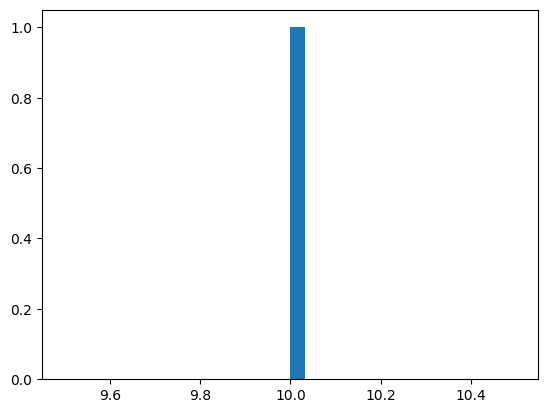

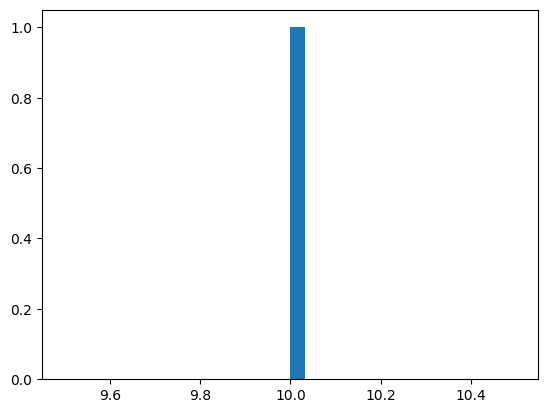

In [ ]:
score, acc = predict_config_accuracy("./config_PE-100.cfg", mymodel, tokenizer)
#y_probability,_ = compute_config_anomaly_vector("./config_PE-100.cfg",mymodel,tokenizer)
#y_words = display_config_anomalies("./config_PE-100.cfg",mymodel,tokenizer)